In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd

/Users/coding/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### I/ Dataset importation and spliting.

#### some hyper parameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

#### data import 

In [6]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory='PlantVillage/Potatoes',
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
)

Found 2152 files belonging to 3 classes.


In [7]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

#### data vizualization

in the following cells , I am going to print some samples from my dataset in order to vizualize some characteristic of them.

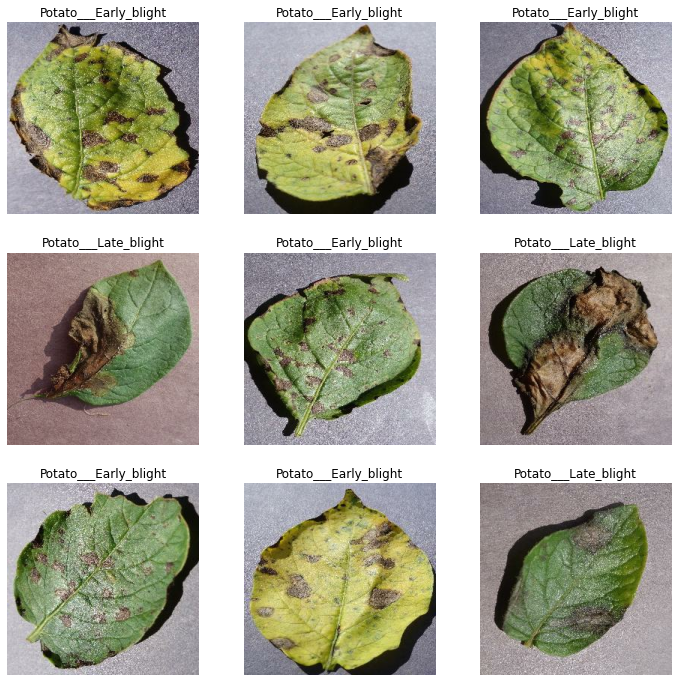

In [25]:
plt.figure(figsize = (12 , 12))

for image_batch , label_batch in dataset.take(1):
    for i in range(9):
        plt.subplot(3 , 3 , i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f'{dataset.class_names[label_batch[i]]}')

#### data spliting

In [74]:
def tf_train_valid_test_split(dataset , train_size = 0.8 , valid_size = 0.1 , test_size = 0.1 , buffer_size = 1000):
    
    """Split the dataset into a train_set , a valid_set and a test_set.

        Parameters
        ----------
        dataset : dataset , required
            the dataset.
            
        train_size : float, default ==> 0.8
            the size of the train_set.
        
        valid_size: float , default ==> 0.1
            the size of the valid set.
            
        test_size: float , default ==> 0.1
            the size of the test set.
            
            
        Returns
        -------
        train_ds : the train dataset
        valid_ds : the valid dataset’
        test_ds  : the test dataset
    
        """
    
    if train_size + valid_size + test_size != 1 :
        raise 'the sum of train_size , valid_size and test_size must be equal to 1'
        
    
    dataset = dataset.shuffle(buffer_size)
    
    
    ds_len     = len(dataset)
    train_size = int(train_size * ds_len)
    valid_size = int(valid_size * ds_len)
    test_size  = int(test_size  * ds_len)
    
    train_ds = dataset.take(train_size)
    valid_ds = dataset.skip(train_size).take(valid_size)
    test_ds  = dataset.skip(train_size).skip(valid_size)
    
    return train_ds , valid_ds , test_ds

In [115]:
train_ds , valid_ds , test_ds = tf_train_valid_test_split(dataset)

### Data preprocessing and Data augmentation

#### Data Preprocessing

In [116]:
## reshape and resize layers

rescale_and_resize = keras.Sequential()
rescale_and_resize.add(keras.layers.Resizing(IMAGE_SIZE , IMAGE_SIZE))
rescale_and_resize.add(keras.layers.Rescaling(1/255))

#### data augmentation

In [117]:
augmentation_layer = keras.Sequential()
augmentation_layer.add(keras.layers.RandomFlip("horizontal_and_vertical"))
augmentation_layer.add(keras.layers.RandomRotation(0.2))
augmentation_layer.add(keras.layers.RandomZoom(0.2))

In [118]:
aug_train_ds = train_ds.map(lambda x , y : (augmentation_layer(x , training = True) , y))

In [119]:
aug_train_ds = train_ds.concatenate(aug_train_ds).shuffle(10)

In [120]:
len(aug_train_ds)

108

In [121]:
aug_train_ds = aug_train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds     = valid_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds      = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

### Model creation

In [136]:
model = keras.Sequential()
model.add(rescale_and_resize)

model.add(keras.layers.Conv2D(filters = 32 , kernel_size = (3,3) ,
                              activation = 'relu' , input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3)))
model.add(keras.layers.MaxPooling2D((3 , 3)))

model.add(keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , activation = 'relu'))
model.add(keras.layers.MaxPooling2D((3 , 3)))

model.add(keras.layers.Conv2D(filters = 64 , kernel_size = (5,5) , activation = 'relu'))
model.add(keras.layers.MaxPooling2D((3 , 3)))

model.add(keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , activation = 'relu'))
model.add(keras.layers.MaxPooling2D((3 , 3)))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64 , activation = 'relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(3 , activation = 'softmax'))

model.build(input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , 3))

In [137]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_76 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_76 (MaxPoolin  (32, 84, 84, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (32, 82, 82, 64)          18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (32, 27, 27, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (32, 23, 23, 64)        

In [138]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3 , decay=1e-6)

In [139]:
model.compile(optimizer= optimizer , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) ,
              metrics = ['accuracy'])

In [140]:
training = model.fit(aug_train_ds , batch_size=BATCH_SIZE , validation_data=valid_ds , epochs = 20 , verbose = 1)

Epoch 1/20
108/108 [==============================] - 82s 756ms/step - loss: 0.7666 - accuracy: 0.6291 - val_loss: 0.6735 - val_accuracy: 0.6845
Epoch 2/20
108/108 [==============================] - 83s 766ms/step - loss: 0.3416 - accuracy: 0.8607 - val_loss: 0.2759 - val_accuracy: 0.9048
Epoch 3/20
108/108 [==============================] - 83s 766ms/step - loss: 0.2813 - accuracy: 0.8881 - val_loss: 0.2260 - val_accuracy: 0.9167
Epoch 4/20
108/108 [==============================] - 268s 2s/step - loss: 0.2293 - accuracy: 0.9170 - val_loss: 0.1684 - val_accuracy: 0.9167
Epoch 5/20
108/108 [==============================] - 88s 818ms/step - loss: 0.2001 - accuracy: 0.9272 - val_loss: 0.0818 - val_accuracy: 0.9524
Epoch 6/20
108/108 [==============================] - 73s 672ms/step - loss: 0.1446 - accuracy: 0.9446 - val_loss: 0.0658 - val_accuracy: 0.9702
Epoch 7/20
108/108 [==============================] - 75s 700ms/step - loss: 0.1396 - accuracy: 0.9493 - val_loss: 0.0599 - val_accu

In [143]:
training.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epochs')

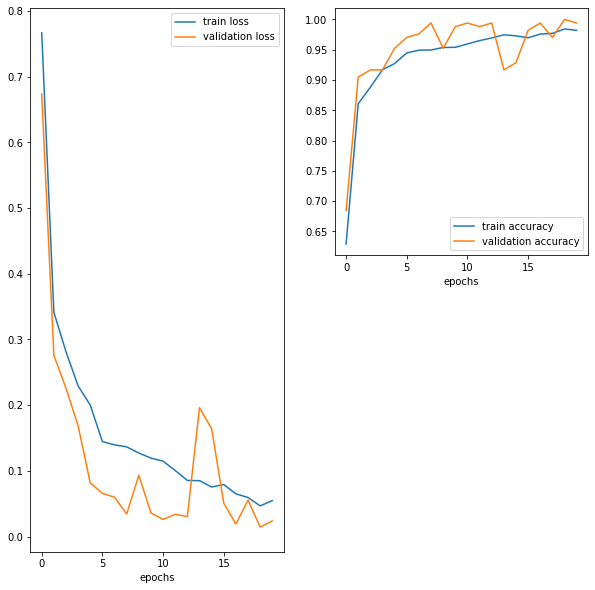

In [150]:
plt.figure(figsize = (10 , 10))
plt.subplot(1 , 2 , 1)
plt.plot(training.history['loss'] , label = 'train loss')
plt.plot(training.history['val_loss'] , label = 'validation loss')
plt.legend()
plt.xlabel('epochs')


plt.subplot(2 , 2 , 2)
plt.plot(training.history['accuracy'] , label = 'train accuracy')
plt.plot(training.history['val_accuracy'] , label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')

In [152]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 143ms/step - loss: 0.0764 - accuracy: 0.9570


we can see that our model is really good on the test set.

In [154]:
import pickle as pkl

pkl.dump(model , open('potatoes_model.obj' , 'wb'))

2022-12-29 22:01:04.464089: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ac509011-e009-4e02-b309-cccc913231b6/assets
